In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import jax
import jax.numpy as jnp
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from idiots.dataset.dataloader import DataLoader
from idiots.experiments.grokking.training import restore, eval_step
from idiots.utils import metrics
import neural_tangents as nt
from einops import rearrange
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from functools import partial
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.ensemble import VotingClassifier

2024-02-20 16:46:07.626911: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 16:46:07.626978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 16:46:07.628689: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-20 16:46:10.358397: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
checkpoint_dir = Path("../idiots/logs/grokking/exp21/checkpoints")
batch_size = 512


def eval_checkpoint(step):
    config, state, ds_train, ds_test = restore(checkpoint_dir, step)

    def eval_loss_acc(ds):
        for batch in DataLoader(ds, batch_size):
            logs = eval_step(state, batch, config.loss_variant)
            metrics.log(**logs)
        [losses, accuracies] = metrics.collect("eval_loss", "eval_accuracy")
        loss = jnp.concatenate(losses).mean().item()
        acc = jnp.concatenate(accuracies).mean().item()
        return loss, acc

    train_loss, train_acc = eval_loss_acc(ds_train)
    test_loss, test_acc = eval_loss_acc(ds_test)

    return state, ds_train, ds_test, train_loss, train_acc, test_loss, test_acc

In [4]:
data = []
for step in range(0, 50000, 10000):
    state, ds_train, ds_test, train_loss, train_acc, test_loss, test_acc = eval_checkpoint(step)
    data.append(
        {
            "step": step,
            "state": state,
            "ds_train": ds_train, 
            "ds_test": ds_test,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "test_loss": test_loss,
            "test_acc": test_acc,
        }
    )

<Axes: xlabel='step', ylabel='accuracy'>

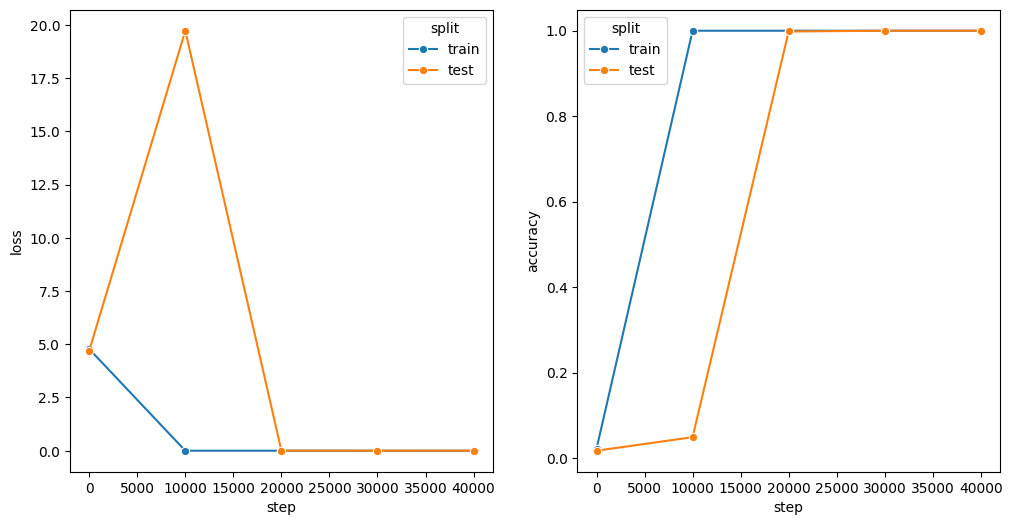

In [5]:
df = pd.DataFrame(data)

df_loss = df[["step", "train_loss", "test_loss"]]
df_loss = df_loss.melt("step", var_name="split", value_name="loss")
df_loss["split"] = df_loss["split"].str.replace("_loss", "")


df_acc = df[["step", "train_acc", "test_acc"]]
df_acc = df_acc.melt("step", var_name="split", value_name="accuracy")
df_acc["split"] = df_acc["split"].str.replace("_acc", "")

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=df_loss, x="step", y="loss", hue="split", marker="o", ax=axs[0])
sns.lineplot(data=df_acc, x="step", y="accuracy", hue="split", marker="o", ax=axs[1])

In [6]:
import gc

In [7]:
df = pd.DataFrame(data)
state_checkpoints = df['state'].tolist()
test_data_checkpoints = df['ds_test'].tolist()

accuracy_checkpoints = [] 

N = 100

assert(len(N * 2 < test_data_checkpoints[0]['x']))

X_train = jnp.array(test_data_checkpoints[0]['x'][:N])
Y_train = jnp.array(test_data_checkpoints[0]['y'][:N])

X_test = jnp.array(test_data_checkpoints[0]['x'][N:2*N])
Y_test = jnp.array(test_data_checkpoints[0]['y'][N:2*N])

for i in range(len(state_checkpoints) - 1, len(state_checkpoints)):

  print("checkpoint:", i)

  state = state_checkpoints[i]

  kernel_fn = nt.empirical_kernel_fn(state.apply_fn, 
        vmap_axes=0,
        implementation=nt.NtkImplementation.STRUCTURED_DERIVATIVES,)
  
  def custom_kernel(X1, X2):
    print(X1.shape, X2.shape)

    kernel = [[None for _ in range(len(X1))] for _ in range(len(X2))]

    for j, X1_item in enumerate(X1): 
      gc.collect()
      print("j:", j)
      kernel_item = kernel_fn(jnp.array([X1_item]), jnp.array(X2), "ntk", state.params)
      kernel[j] = kernel_item[0]

    return kernel 

  svc = SVC(kernel=custom_kernel)
  svc.fit(X_train, Y_train)

  predictions = svc.predict(X_test)
  accuracy = accuracy_score(Y_test, predictions)

  accuracy_checkpoints.append(accuracy)

print(accuracy_checkpoints)


checkpoint: 4
(100, 4) (100, 4)
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
j: 14
j: 15
j: 16
j: 17
j: 18
j: 19
j: 20
j: 21
j: 22
j: 23
j: 24
j: 25
j: 26
j: 27
j: 28
j: 29
j: 30
j: 31
j: 32
j: 33
j: 34
j: 35
j: 36
j: 37
j: 38
j: 39
j: 40
j: 41
j: 42
j: 43
j: 44
j: 45
j: 46
j: 47
j: 48
j: 49
j: 50
j: 51
j: 52
j: 53
j: 54
j: 55
j: 56
j: 57
j: 58
j: 59
j: 60
j: 61
j: 62
j: 63
j: 64
j: 65
j: 66
j: 67
j: 68
j: 69
j: 70
j: 71
j: 72
j: 73
j: 74
j: 75
j: 76
j: 77
j: 78
j: 79
j: 80
j: 81
j: 82
j: 83
j: 84
j: 85
j: 86
j: 87
j: 88
j: 89
j: 90
j: 91
j: 92
j: 93
j: 94
j: 95
j: 96
j: 97
j: 98
j: 99
(100, 4) (100, 4)
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
j: 14
j: 15
j: 16
j: 17
j: 18
j: 19
j: 20
j: 21
j: 22
j: 23
j: 24
j: 25
j: 26
j: 27
j: 28
j: 29
j: 30
j: 31
j: 32
j: 33
j: 34
j: 35
j: 36
j: 37
j: 38
j: 39
j: 40
j: 41
j: 42
j: 43
j: 44
j: 45
j: 46
j: 47
j: 48
j: 49
j: 50
j: 51
j: 52
j: 53
j: 54
j: 55
j: 56
j: 57
j: 58
j: 59
j: 60
j: 6